In [ ]:
# Importamos las librerias necesarias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Cargamos los datasets
df_games_full = pd.read_csv("../data/processed/dataset_games_full.csv")
df_reviews = pd.read_csv("../data/processed/dataset_reviews.csv")
df_users = pd.read_csv("../data/processed/users.csv")

In [5]:
# Credibilidad de los usuarios
full_helpful_user = df_reviews.groupby("user_id")["helpful"].sum().reset_index() # Agrupamos por user_id y sumamos la columna helpful
full_helpful_user.rename(columns={"helpful": "total_helpful"}, inplace=True) # Renombramos la columna helpful a total_helpful
df_users = df_users.merge(full_helpful_user, on="user_id", how="left") # Unimos el dataframe df_users con el dataframe full_helpful_user por la columna user_id
df_users["total_helpful"] = df_users["total_helpful"].fillna(0) # Rellenamos los valores nulos de la columna total_helpful con 0
df_users["credibility"] = df_users["total_helpful"] / (df_users["reviews"] + 1) # Calculamos la credibilidad dividiendo la columna total_helpful entre la columna reviews + 1 para evitar divisiones por cero
print("La media de reviews por usuario es: ", df_users["reviews"].mean()) # Mostramos la media de reviews por usuario
df_trusted_users = df_users[df_users["reviews"] >= 3] # Filtrar usuarios con al menos 3 reseñas publicadas

# Mostrar resumen
print("Usuarios con al menos 3 reviews:")
display(df_trusted_users[["user_id", "reviews", "total_helpful", "credibility"]].sort_values("credibility", ascending=False).head())


La media de reviews por usuario es:  2.8767377246459964
Usuarios con al menos 3 reviews:


,user_id,reviews,total_helpful,credibility
3377614,626194,3,19736.0,4934.00
9214747,451002,3,16965.0,4241.25
6580022,3087416,4,19421.0,3884.20
12675724,2076702,3,14837.0,3709.25
8328546,6611547,3,14641.0,3660.25


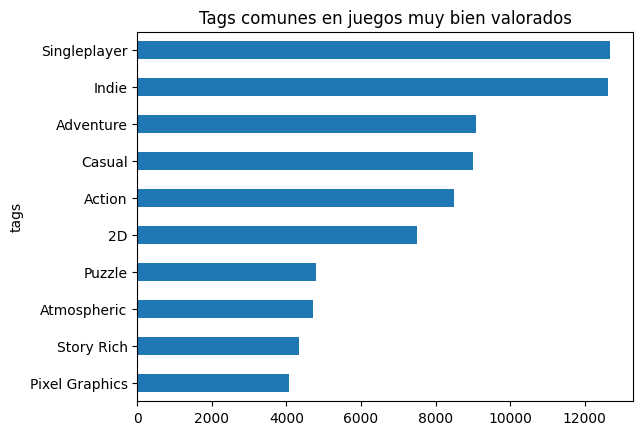

Juegos bien valorados con número mayor numero de recomendaciones de usuarios confiables:


,title,positive_ratio,total_recomendations
23958,Team Fortress 2,93,195449.0
8686,The Witcher® 3: Wild Hunt,96,131624.0
10898,DARK SOULS™ III,94,131408.0
8928,Fallout 4,83,129724.0
9864,Tom Clancy's Rainbow Six® Siege,86,114490.0


Juegos bien valorados con mayor ratio de recomendaciones de usuarios confiables:


,title,positive_ratio,recommendation_ratio
26056,Repella Fella: Prologue,98,1.0
26055,Last Meow Standing,100,1.0
26046,Fabular: Prologue,96,1.0
26111,Synthalaxy,100,1.0
26109,Overstrike Arena,100,1.0


In [18]:
# Que tipo de juego son exitosos según sus reseñas por usuarios confiables
df_highrated_games = df_games_full[df_games_full["positive_ratio"] > 80]
df_highrated_games["tags"].str.split(", ").explode().value_counts().head(10).plot(kind="barh", title="Tags comunes en juegos muy bien valorados")
plt.gca().invert_yaxis()
plt.show()
recommended_game = df_reviews[df_reviews["user_id"].isin(df_trusted_users["user_id"])]
# Agregamos total_recomendation y good_recommendations por juego.
total_recommendations = recommended_game.groupby("app_id")["is_recommended"].size().reset_index(name="total_recomendations")
good_recommendations = recommended_game[recommended_game["is_recommended"] == True].groupby("app_id").size().reset_index(name="good_recomendations")
# Unimos las nuevas columnas al dataframe df_highrated_games
df_highrated_games = df_highrated_games.merge(total_recommendations, on="app_id", how="left")
df_highrated_games = df_highrated_games.merge(good_recommendations, on="app_id", how="left")
# Modificamos los campos NaN a 0
df_highrated_games["total_recomendations"] = df_highrated_games["total_recomendations"].fillna(0)
# Creamos un Ratio de recomendación partiendo de los datos anteriormente obtenidos 
df_highrated_games["recommendation_ratio"] = df_highrated_games["good_recomendations"] / df_highrated_games["total_recomendations"]
# Mostramos la visualización de los juegos mejor valorados
print("Juegos bien valorados con número mayor numero de recomendaciones de usuarios confiables:")
display(df_highrated_games[["title", "positive_ratio", "total_recomendations"]].sort_values("total_recomendations", ascending=False).head())
print("Juegos bien valorados con mayor ratio de recomendaciones de usuarios confiables:")
display(df_highrated_games[["title", "positive_ratio", "recommendation_ratio"]].sort_values("recommendation_ratio", ascending=False).head())


Juegos mejor valorados con mayor índice de éxito:


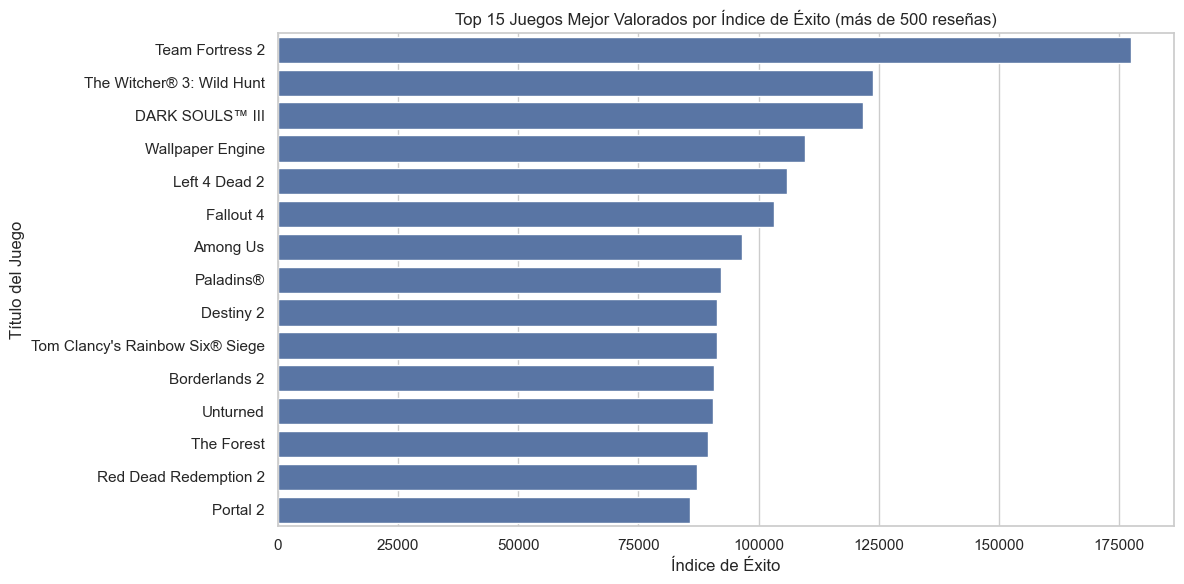

In [ ]:
# Crear un índice de éxito basado en recomendaciones y valoraciones
df_highrated_games["success_index"] = df_highrated_games["total_recomendations"] * df_highrated_games["recommendation_ratio"]
# Ordenar por índice de éxito y ver los mejores juegos eliminando los que menores reseñas tienen
print("Juegos mejor valorados con mayor índice de éxito:")
# Filtrar y ordenar por índice de éxito
top_success_games = df_highrated_games[df_highrated_games["total_recomendations"] > 500].sort_values("success_index", ascending=False).head(15)
# Gráfico de barras horizontales
plt.figure(figsize=(12, 6))
sns.barplot(data=top_success_games, x="success_index", y="title")
plt.title("Top 15 Juegos Mejor Valorados por Índice de Éxito (más de 500 reseñas)")
plt.xlabel("Índice de Éxito")
plt.ylabel("Título del Juego")
plt.tight_layout()
plt.show()
